In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [324]:
uYield = pd.read_csv('ConstantMaturities.csv', index_col = 0, parse_dates = True)

<Axes: title={'center': 'Yield evolution'}, xlabel='Date'>

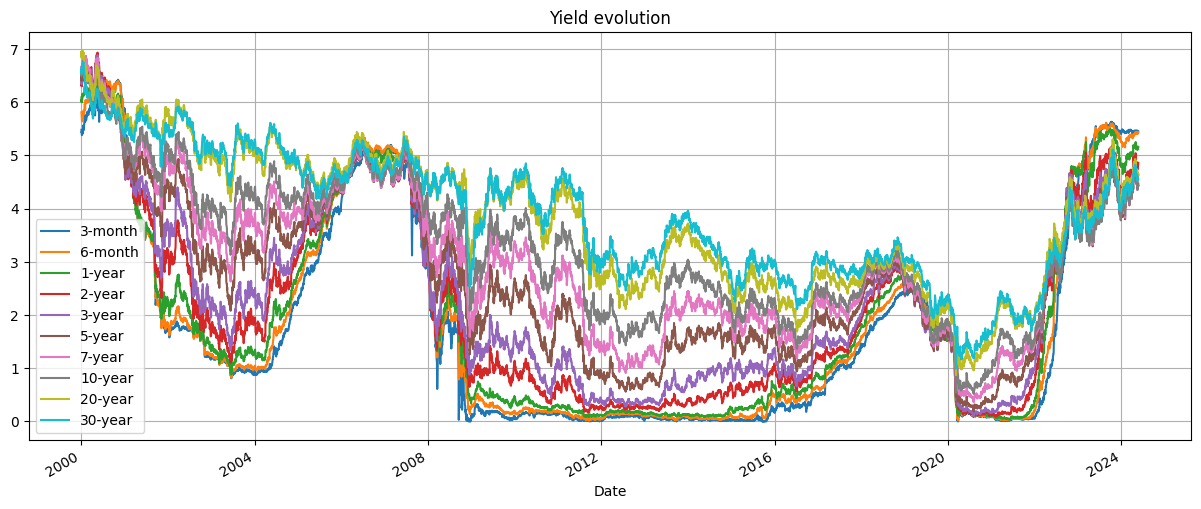

In [344]:
uYield.plot(figsize = (15, 6), grid = True, title = 'Yield evolution')

In [347]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(timeseries):
    result = adfuller(timeseries)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

# Apply ADF test on each maturity rate
adf_results = {column: adf_test(uYield[column]) for column in uYield.columns}

# Display the ADF test results
adf_results_df = pd.DataFrame(adf_results).T
adf_results_df[['ADF Statistic', 'p-value']]


,ADF Statistic,p-value
3-month,-1.707357,0.427326
6-month,-1.804738,0.378112
1-year,-1.702301,0.429927
2-year,-2.233559,0.194292
3-year,-2.260166,0.185137
5-year,-2.339511,0.159541
7-year,-2.504235,0.114447
10-year,-2.519285,0.110852
20-year,-2.424748,0.134873
30-year,-2.429034,0.133709


In [327]:
from sklearn.model_selection import train_test_split
uYield_train, uYield_test = train_test_split(uYield, test_size = 0.2, shuffle = False)

In [328]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Perform Johansen cointegration test
coint_test_result = coint_johansen(uYield_train, det_order=0, k_ar_diff=1)

# Extract test statistics and critical values
coint_test_summary = {
    'Eigenvalues': coint_test_result.eig,
    'Trace Statistic': coint_test_result.lr1,
    'Critical Value (90%)': coint_test_result.cvt[:, 0],
    'Critical Value (95%)': coint_test_result.cvt[:, 1],
    'Critical Value (99%)': coint_test_result.cvt[:, 2],
}

coint_test_summary_df = pd.DataFrame(coint_test_summary)
coint_test_summary_df


,Eigenvalues,Trace Statistic,Critical Value (90%),Critical Value (95%),Critical Value (99%)
0,0.042450,826.116521,232.1030,239.2468,253.2526
1,0.041351,614.479232,190.8714,197.3772,210.0366
2,0.028777,408.439020,153.6341,159.5290,171.0905
3,0.022655,265.976338,120.3673,125.6185,135.9825
4,0.011682,154.172848,91.1090,95.7542,104.9637
5,0.009027,96.838370,65.8202,69.8189,77.8202
6,0.004970,52.595388,44.4929,47.8545,54.6815
7,0.003436,28.285075,27.0669,29.7961,35.4628
8,0.001506,11.493565,13.4294,15.4943,19.9349
9,0.000849,4.142654,2.7055,3.8415,6.6349


<Axes: xlabel='Date'>

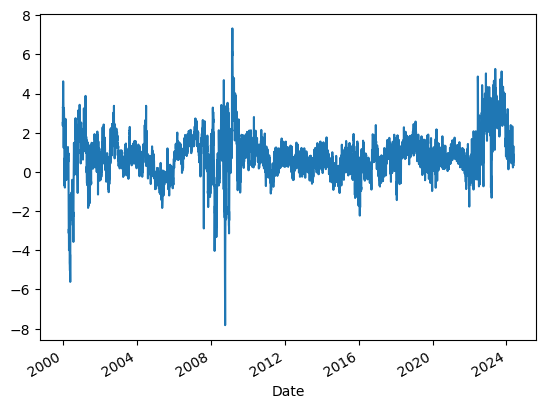

In [329]:
(uYield * coint_test_result.evec[:, 0]).sum(axis = 1).plot()

In [330]:
ncol = len(uYield.columns)
col_name = uYield.columns
trace_stat = pd.DataFrame(index = col_name, columns = col_name)
crital_value_95 = pd.DataFrame(index = col_name, columns = col_name)
reject_null = pd.DataFrame(index = col_name, columns = col_name)
eigenVectors = pd.DataFrame(index = col_name, columns = col_name)

for i in range(ncol):
    for j in range(i + 1, ncol):
        coint_test = coint_johansen(uYield_train[[col_name[i], col_name[j]]], det_order=0, k_ar_diff=1)
        trace_stat.iloc[i, j] = coint_test.lr1[0]
        crital_value_95.iloc[i, j] = coint_test.cvt[0, 1]
        reject_null.iloc[i, j] = (coint_test.lr1[0] > coint_test.cvt[0, 1]) * 1
        eigenVectors.iloc[i, j] = coint_test.evec[:, 0]

In [348]:
trace_stat

,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year
3-month,NaN,105.672901,72.020209,50.477974,32.399735,17.437226,13.567883,11.043822,8.855981,9.038284
6-month,NaN,NaN,60.3571,45.099833,28.527976,14.915785,11.990479,10.510184,9.922652,10.071221
1-year,NaN,NaN,NaN,39.90001,23.348664,13.518149,11.773586,11.077011,10.573078,10.690947
2-year,NaN,NaN,NaN,NaN,15.182834,11.981184,11.391304,11.075805,9.787915,10.019489
3-year,NaN,NaN,NaN,NaN,NaN,12.701071,11.332583,10.691193,8.978149,9.453938
5-year,NaN,NaN,NaN,NaN,NaN,NaN,12.035779,10.193462,8.24576,9.015199
7-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.833767,8.567326,9.610683
10-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.471421,10.338029
20-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.798997
30-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [349]:
crital_value_95

,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year
3-month,NaN,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943
6-month,NaN,NaN,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943
1-year,NaN,NaN,NaN,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943
2-year,NaN,NaN,NaN,NaN,15.4943,15.4943,15.4943,15.4943,15.4943,15.4943
3-year,NaN,NaN,NaN,NaN,NaN,15.4943,15.4943,15.4943,15.4943,15.4943
5-year,NaN,NaN,NaN,NaN,NaN,NaN,15.4943,15.4943,15.4943,15.4943
7-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.4943,15.4943,15.4943
10-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.4943,15.4943
20-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.4943
30-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [331]:
reject_null

,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year
3-month,NaN,1,1,1,1,1,0,0,0,0
6-month,NaN,NaN,1,1,1,0,0,0,0,0
1-year,NaN,NaN,NaN,1,1,0,0,0,0,0
2-year,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3-year,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
5-year,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
7-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
10-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
20-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
30-year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
rc_idx = np.where(reject_null == 1)

In [333]:
coint_pairs = []
for r, c in zip(rc_idx[0], rc_idx[1]):
    coint_pairs.append([col_name[r], col_name[c]])

In [334]:
coint_paris_ts = pd.DataFrame()
n = len(coint_pairs)
for i in range(n):
    coint_paris_ts[' & '.join(coint_pairs[i])] = (uYield[coint_pairs[i]] * eigenVectors.loc[coint_pairs[i][0], coint_pairs[i][1]]).sum(axis = 1)

In [335]:
coint_paris_ts.tail()

,3-month & 6-month,3-month & 1-year,3-month & 2-year,3-month & 3-year,3-month & 5-year,6-month & 1-year,6-month & 2-year,6-month & 3-year,1-year & 2-year,1-year & 3-year,20-year & 30-year
Date,,,,,,,,,,,
2024-05-16,1.218078,1.405551,1.182318,0.779690,-0.221175,1.128312,0.941241,0.549678,0.760644,0.350504,-4.608750
2024-05-17,1.307375,1.405330,1.077233,0.757758,-0.271806,1.048430,0.789083,0.505756,0.583399,0.321050,-4.655573
2024-05-20,1.042668,1.310159,1.078261,0.699105,-0.315563,1.124214,0.876770,0.501049,0.669750,0.291597,-4.678984
2024-05-21,1.130373,1.357855,1.078261,0.719251,-0.268369,1.126263,0.848142,0.503402,0.627332,0.293832,-4.643867
2024-05-22,1.042668,1.262463,0.974205,0.658813,-0.331294,1.044333,0.755043,0.457127,0.536438,0.262143,-4.780304


In [336]:
def plot_data_ts(data, size):
    df = pd.DataFrame(data)
    nrows = int(np.ceil(data.shape[1]) / 3) + 1
    fig, axes = plt.subplots(nrows = nrows, ncols = 3, figsize = size)
    for i in range(len(df.columns)):
        df[df.columns[i]].plot(ax = axes[i//3][i%3], title = df.columns[i])
        axes[i//3][i%3].grid(alpha=0.3)
        axes[i//3][i%3].vlines(uYield_test.index[0], df[df.columns[i]].min(), df[df.columns[i]].max(), colors = 'red', linestyles = '--')
    plt.tight_layout()

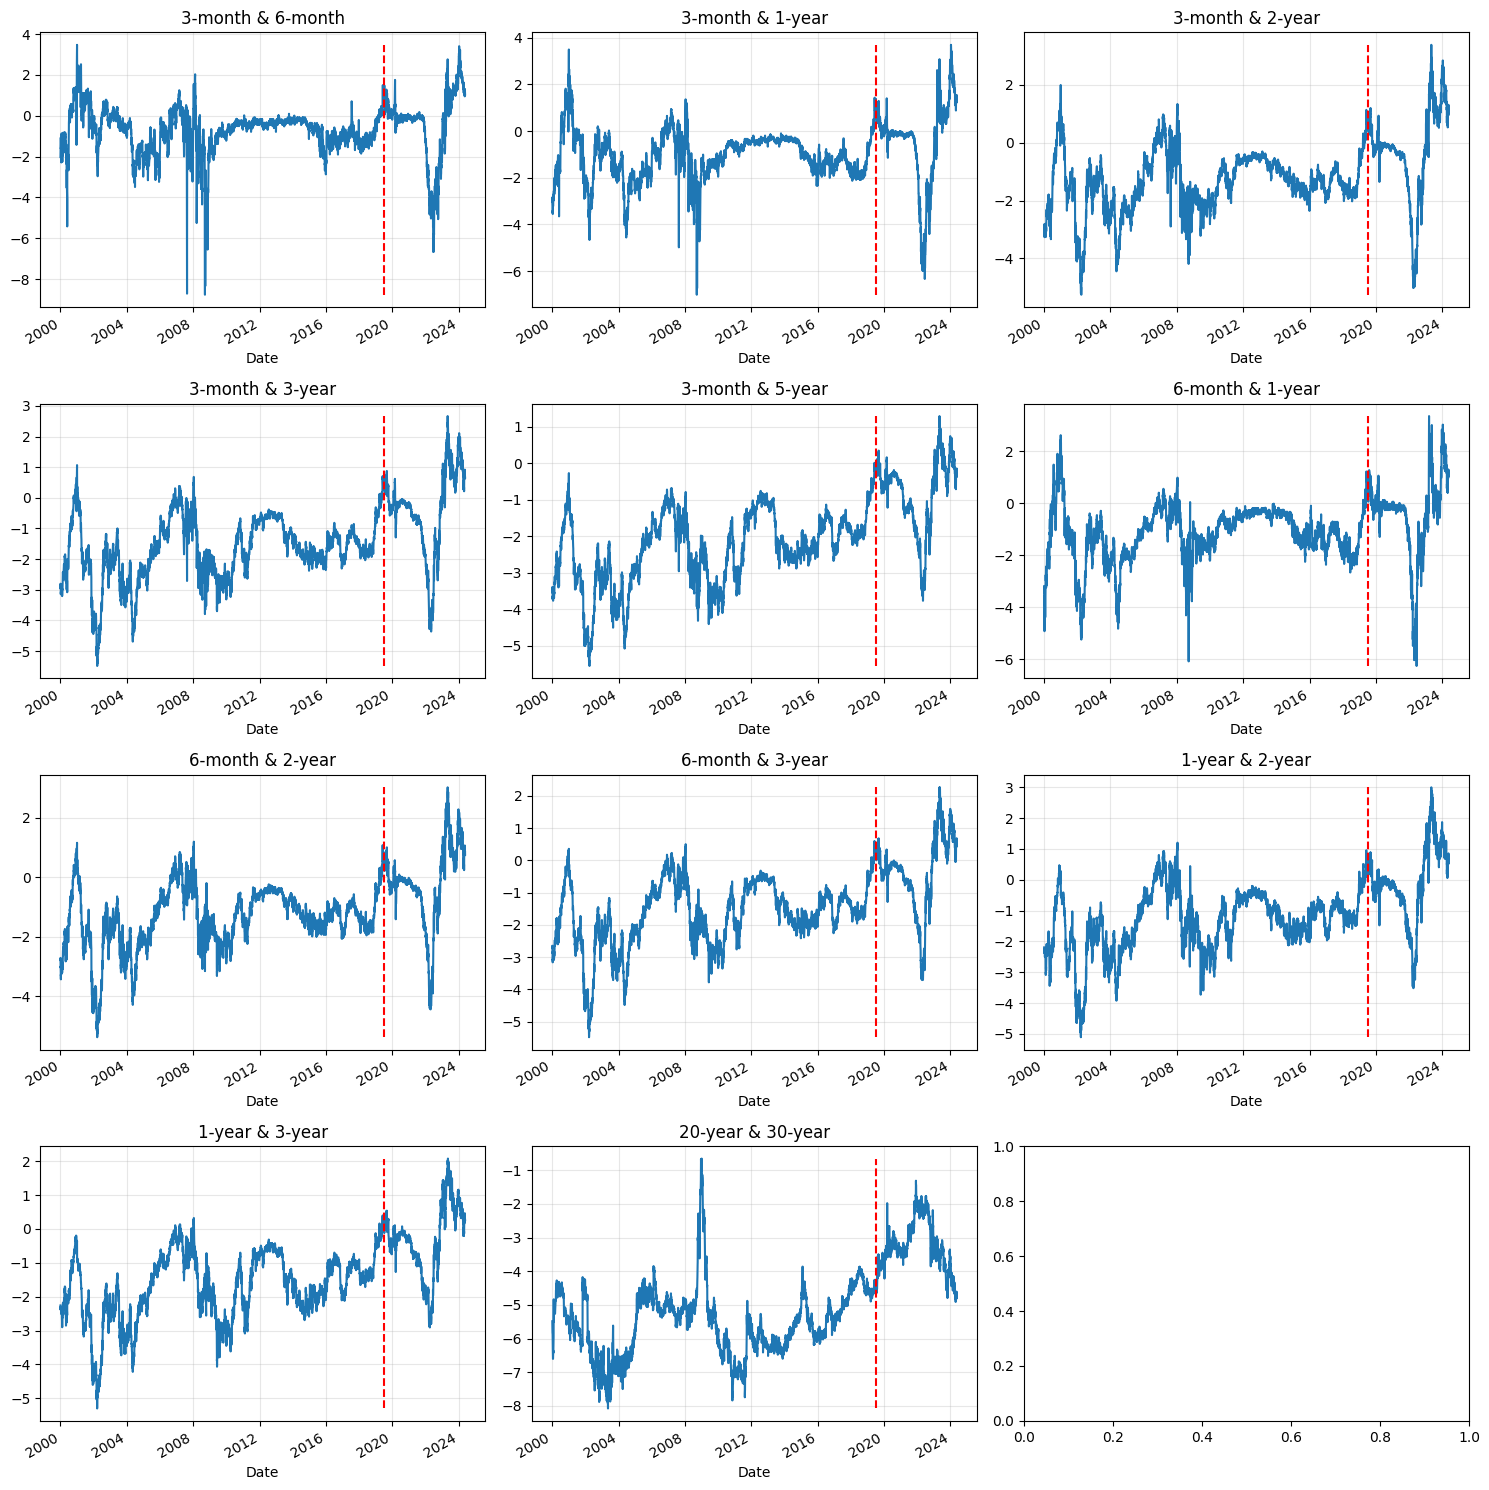

In [337]:
plot_data_ts(coint_paris_ts, (15, 15))

In [338]:
data = uYield[['3-month', '5-year']]

In [339]:
from pykalman import KalmanFilter
# Extract closing prices
s1 = data[['3-month']].values
s2 = data[['5-year']].values

# Prepare data for Kalman Filter
H = np.insert(s1, s1.shape[1], 1, axis=1)
H = H.reshape(len(s1), 1, 2)
F = np.eye(2)
Q = [[1e-4, 0], [0, 1e-4]]
R = 1
X0 = [0, 0]
P0 = [[1, 0], [0, 1]]

# Initialize Kalman Filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  transition_matrices=F,
                  observation_matrices=H,
                  transition_covariance=Q,
                  observation_covariance=R,
                  initial_state_mean=X0,
                  initial_state_covariance=P0)

# Filtering
state_means, state_covs = kf.filter(s2)

# Extract beta (slope) and intercept from state_means
beta = state_means[:, 0]
intc = state_means[:, 1]

# Reshape beta and intercept arrays
beta = beta.reshape(len(beta), 1)
intc = intc.reshape(len(intc), 1)

# Restore EWC based on EWA and estimated parameters
s2_restored = (s1 * beta + intc)


In [340]:
data['beta'] = beta
data['intc'] = intc
data['const'] = 1
data['residuals'] = s2 - s2_restored

/var/folders/l2/g62nwg6n517g5516gcjv7mh80000gn/T/ipykernel_72692/1281191172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beta'] = beta
/var/folders/l2/g62nwg6n517g5516gcjv7mh80000gn/T/ipykernel_72692/1281191172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intc'] = intc
/var/folders/l2/g62nwg6n517g5516gcjv7mh80000gn/T/ipykernel_72692/1281191172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [341]:
data['residuals'].quantile(0.025), data['residuals'].quantile(0.975)

(-0.6346007884005669, 0.5390615884380242)

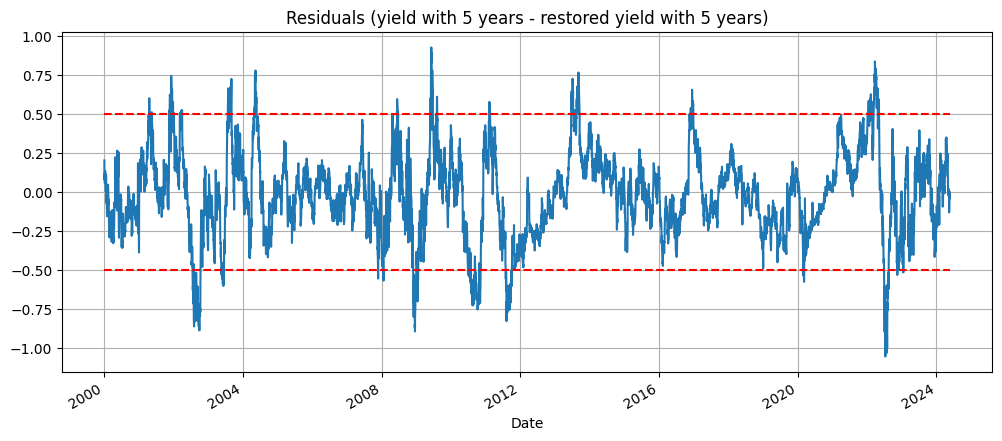

In [355]:
data['residuals'].plot(grid = True, title = 'Residuals (yield with 5 years - restored yield with 5 years)', figsize=(12,5))
plt.hlines(0.5 ,xmin=data.index[0], xmax = data.index[-1], linestyles='--', colors='red')
plt.hlines(-0.5 ,xmin=data.index[0], xmax = data.index[-1], linestyles='--', colors='red')

In [362]:
position = data[['const', 'beta']]
position['beta'] = position['beta'] * -1

price = data[['5-year', '3-month']]
rtn = price.diff(1)

signal = ((data['residuals'] > 0.5) * -1 + (data['residuals'] < -0.5) * 1).replace(0, np.nan).ffill()
# signal.plot()
position = position.mul(signal, axis = 0)

/var/folders/l2/g62nwg6n517g5516gcjv7mh80000gn/T/ipykernel_72692/3365023954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position['beta'] = position['beta'] * -1


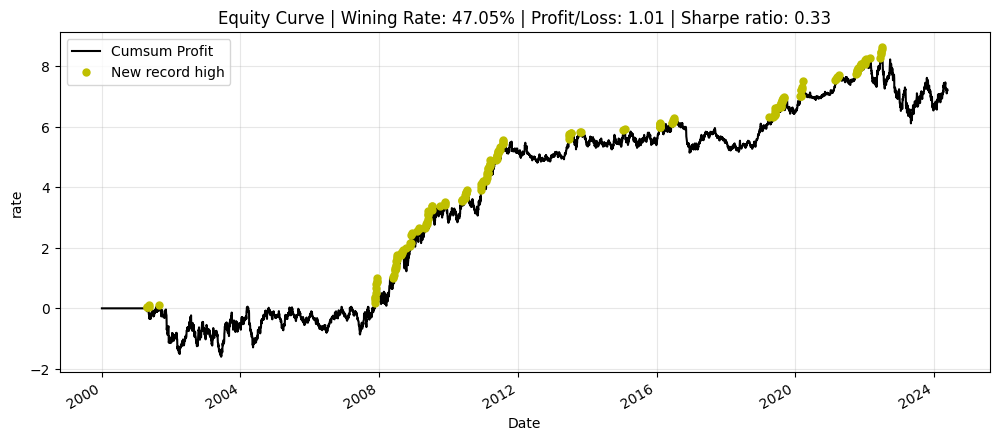

In [376]:
profit = (position.shift(1) * rtn.values).sum(axis = 1).dropna().to_frame('return')
ec_ = profit.cumsum()

wining_rate = (len(profit[profit>0].dropna()) / len(profit)) * 100
pdivl = - profit[profit>0].mean() / profit[profit<0].mean()
sr = profit.mean() * 252 / profit.std() / np.sqrt(252)
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
ec_.plot(ax=axes, color='black')
cumProfit = ec_.cummax()
cumProfit = (cumProfit-cumProfit.shift(1)).replace(0, np.nan)+cumProfit.shift(1)
cumProfit.plot(ax=axes, style='yo',markersize=5)

axes.grid(alpha=0.3)
axes.set_title(f"Equity Curve | Wining Rate: {wining_rate:.2f}% | Profit/Loss: {pdivl.values[0]:.2f} | Sharpe ratio: {sr.iloc[0]:.2f}")
axes.set_ylabel('rate')
axes.legend(['Cumsum Profit', 'New record high'])

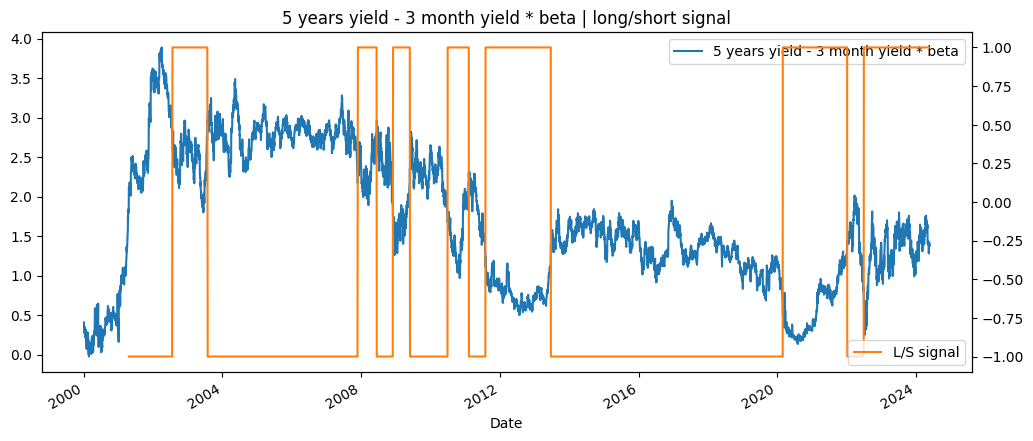

In [403]:
(data['5-year'] - data['3-month'] * data['beta']).plot(figsize=(12, 5), title='5 years yield - 3 month yield * beta | long/short signal')
plt.legend(['5 years yield - 3 month yield * beta', 'df'], loc=4)
signal.plot(secondary_y=True)
plt.legend(['L/S signal'], loc = 4)

In [378]:
dd = (ec_ - ec_.cummax())['return']
dd.min()

-2.5080976921193434

<Axes: title={'center': 'beta adn intc'}, xlabel='Date'>

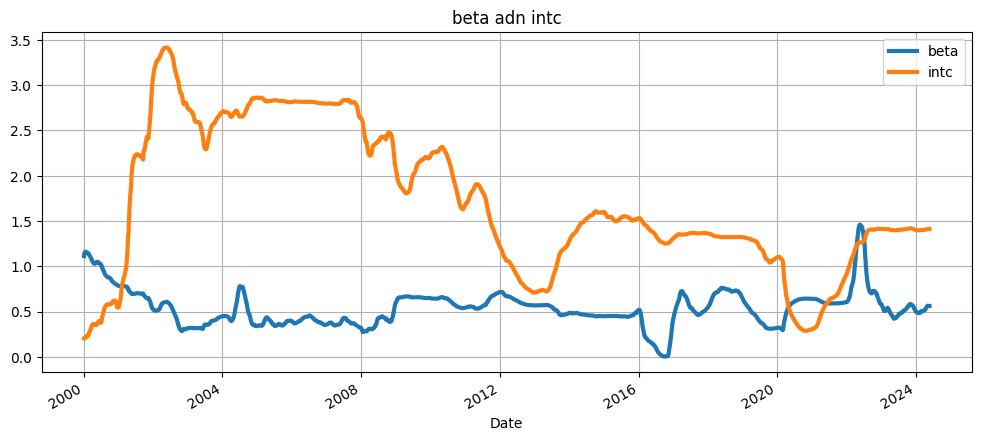

In [361]:
data[['beta', 'intc']].plot(figsize=(12,5), grid=True, title='beta adn intc', linewidth = 3)